# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('azdias shape is', azdias.shape)
print('feat_info shape is', feat_info.shape)

azdias shape is (891221, 85)
feat_info shape is (85, 4)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
for index, row in feat_info.iterrows():
    values = row['missing_or_unknown'].replace('[','').replace(']','').split(',')
    #print(index, values)
    for i in values:
        if i == '':
            True
        elif i == 'X' or i == 'XX':
            azdias[row['attribute']].replace(i, np.nan, inplace=True)
        else: 
            azdias[row['attribute']].replace(float(i), np.nan, inplace=True) 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum(axis=0).sort_values(ascending=False).head(10)

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
REGIOTYP          158064
KKK               158064
W_KEIT_KIND_HH    147988
KBA05_ANTG4       133324
dtype: int64

In [9]:
nans = azdias.isnull().sum(axis=0)
nans.groupby(nans).size().sort_index(ascending=False)

889061     1
685843     1
584612     1
476524     1
392318     1
310267     1
158064     2
147988     1
133324     6
116515     7
111196     3
108315     1
108164     1
105800     1
99611      1
99352      3
97632      1
97375      2
97274      1
97008      1
94572      1
93740      3
93155      1
93148      4
77792      2
73969      1
73499      4
18348      1
4854       6
2881       1
0         24
dtype: int64

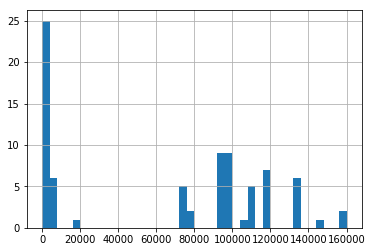

In [10]:
# Investigate patterns in the amount of missing data in each column.
azdias.isnull().sum(axis=0).hist(range=(0,160000), bins= 40);

In [11]:
max_number_of_nans = 200000
helper = azdias.isnull().sum(axis=0)
dropped_columns = helper[helper > max_number_of_nans].sort_values(ascending=False).index.tolist()
dropped_columns

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(azdias.columns[azdias.apply(lambda col: col.isnull().sum(axis=0) > max_number_of_nans)], axis=1)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

*(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)*

**There were a few columns with a tremendous amount of missing values. 6 columns had more than 200,000 missing out of the almost 900K values. I removed them (AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX). Then there were 24 columns with 0 missing values. Furthermore, there were patterns in terms of that multiple columns had the exact same number of missing values, for example 7 columns related to ZIP code with 116515. A lot of these groupings look like one hot encoded features.**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1).sort_values(ascending=False).head(10)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
dtype: int64

In [14]:
nans = azdias.isnull().sum(axis=1)
nans = nans.groupby(nans).size().sort_index(ascending=False)
print(nans.head(5), nans.tail(5))

49        2
48        1
47    45578
45      494
44      155
dtype: int64 4     12607
3     17629
2     27926
1     15738
0    623209
dtype: int64


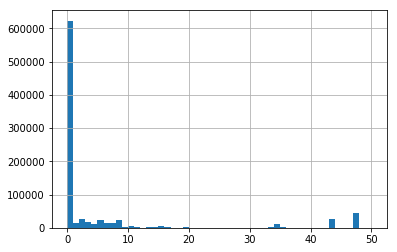

In [15]:
azdias.isnull().sum(axis=1).hist(range=(0,50), bins= 50);

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 10
subset_fullval = azdias[azdias.isnull().sum(axis=1) < threshold]
subset_missval = azdias[azdias.isnull().sum(axis=1) >= threshold]
print('subset_fullval shape =', subset_fullval.shape, 'subset_missval shape =', subset_missval.shape)

subset_fullval shape = (774743, 79) subset_missval shape = (116478, 79)


In [17]:
# Adding dataset value to distinguish in desired merged dataframe 
subset_fullval['dataset'] = 'fullval'
subset_missval['dataset'] = 'missval'
print('subset_fullval shape =', subset_fullval.shape, 'subset_missval shape =', subset_missval.shape)

subset_fullval shape = (774743, 80) subset_missval shape = (116478, 80)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_value_distribution(list_columns):
    rows = len(list_columns)
    size = (12, rows*4)
    base_color = sns.color_palette()[0]
    
    fig, ax = plt.subplots(ncols=2, nrows=rows, figsize=size);
    plt.subplots_adjust(hspace = 0.2);
    
    for i in range(rows):
        if i == 0:
            sns.countplot(x=list_columns[i], data=subset_fullval, color=base_color, ax=ax[i,0]).set_title('subset_fullval')       
            sns.countplot(x=list_columns[i], data=subset_missval, color=base_color, ax=ax[i,1]).set_title('subset_missval')
        else:
            sns.countplot(x=list_columns[i], data=subset_fullval, color=base_color, ax=ax[i,0])       
            sns.countplot(x=list_columns[i], data=subset_missval, color=base_color, ax=ax[i,1])

In [19]:
#random column selection
pd.Series(subset_fullval.columns).sample(n=5).tolist()

['LP_FAMILIE_FEIN', 'FINANZTYP', 'GEBAEUDETYP', 'SEMIO_ERL', 'ZABEOTYP']

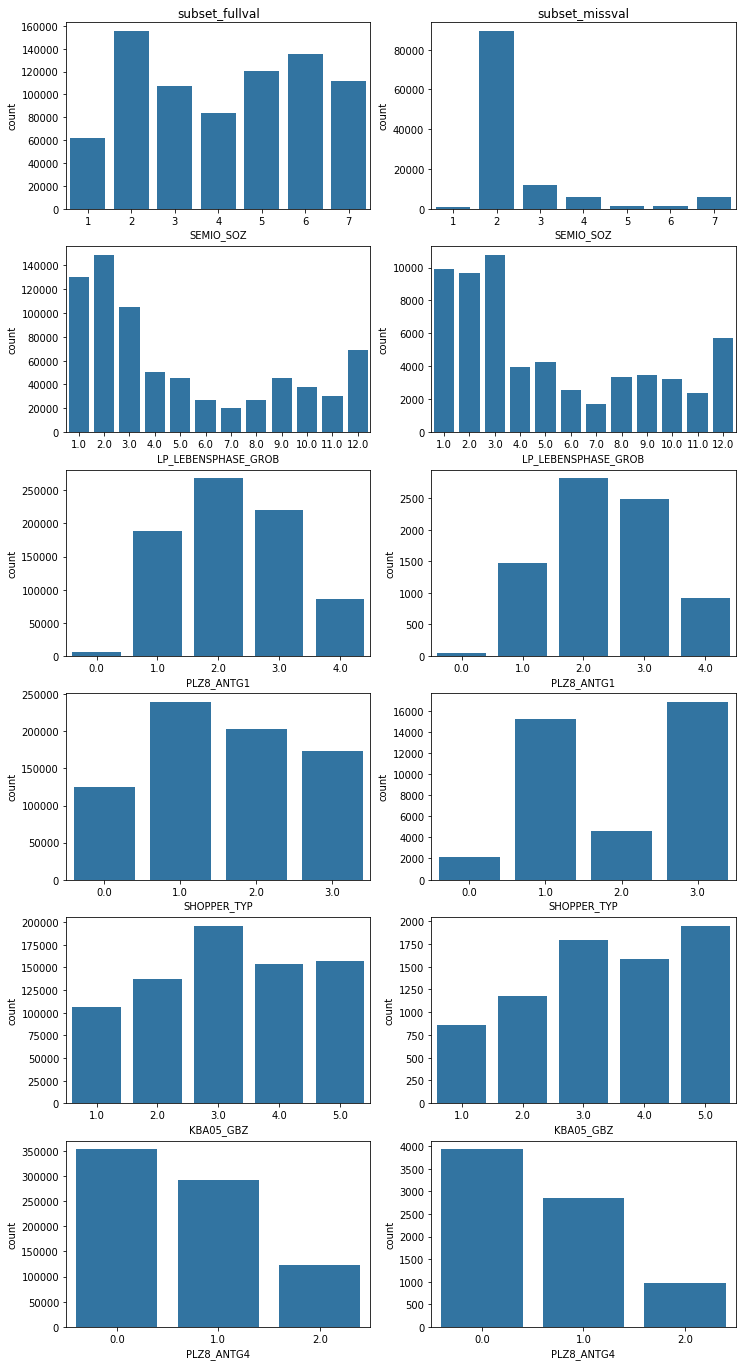

In [20]:
list_columns = pd.Series(subset_fullval.columns).sample(n=6).tolist()
plot_value_distribution(list_columns)

#### Discussion 1.1.3: Assess Missing Data in Each Row

*(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)*

**I would argue the data with lots of missing values (threshold defined by me is 10) is qualitatively different from data with few or no missing values. For some (not for all) of the columns the patterns in distribution are different than for the datasaet with few missing values. Therefore, I would treat the subsets differently.**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
list_cat_features = feat_info['attribute'][feat_info['type'] == 'categorical'].tolist()

for feature in list_cat_features:
    if feature in dropped_columns:
        True
    else:
        list = azdias[feature].unique()
        print(feature, list, len(list))
        if len(list) > 3:
            azdias.drop(columns=feature, inplace=True)
            print('Column dropped')
            dropped_columns.append(feature)
dropped_columns

ANREDE_KZ [1 2] 2
CJT_GESAMTTYP [ 2.  5.  3.  4.  1.  6. nan] 7
Column dropped
FINANZTYP [4 1 6 5 2 3] 6
Column dropped
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan] 13
Column dropped
GREEN_AVANTGARDE [0 1] 2
LP_FAMILIE_FEIN [ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.] 12
Column dropped
LP_FAMILIE_GROB [ 2.  3.  1. nan  5.  4.] 6
Column dropped
LP_STATUS_FEIN [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan] 11
Column dropped
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan] 6
Column dropped
NATIONALITAET_KZ [nan  1.  3.  2.] 4
Column dropped
SHOPPER_TYP [nan  3.  2.  1.  0.] 5
Column dropped
SOHO_KZ [nan  1.  0.] 3
VERS_TYP [nan  2.  1.] 3
ZABEOTYP [3 5 4 1 6 2] 6
Column dropped
GEBAEUDETYP [nan  8.  1.  3.  2.  6.  4.  5.] 8
Column dropped
OST_WEST_KZ [nan 'W' 'O'] 3
CAMEO_DEUG_2015 [nan '8' '4' '2' '6' '1' '9' '5' '7' '3'] 10
Column dropped
CAMEO_DEU_2015 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias['OST_WEST_KZ'][azdias['OST_WEST_KZ'] == 'W'] = 1
azdias['OST_WEST_KZ'][azdias['OST_WEST_KZ'] == 'O'] = 0
azdias.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*

**There were 21 categorical features after initially dropping the features with too many missing values. I modified the binary column `OST_WEST_KZ` so that it has a numeric value instead of a letter. I dropped all categorical columns where the unique value count is bigger than 3 (all columns with count 3 where binary with nans).**

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
feat_info['attribute'][feat_info['type'] == 'mixed']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE"
print(azdias['PRAEGENDE_JUGENDJAHRE'].unique())
print(azdias['PRAEGENDE_JUGENDJAHRE'].head())

# engineer two new variables
conditions_decade = [
    (azdias['PRAEGENDE_JUGENDJAHRE'].isin([1.,2.])),
    (azdias['PRAEGENDE_JUGENDJAHRE'].isin([3.,4.])),
    (azdias['PRAEGENDE_JUGENDJAHRE'].isin([5.,6.,7.])),
    (azdias['PRAEGENDE_JUGENDJAHRE'].isin([8.,9.])),
    (azdias['PRAEGENDE_JUGENDJAHRE'].isin([10.,11.,12.,13.])),
    (azdias['PRAEGENDE_JUGENDJAHRE'].isin([14.,15.]))]

choices_decade = [40, 50, 60, 70, 80, 90]

conditions_movement = [
    (azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14])),
    (azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]))]

choices_movement = [1, 0] # 1 is Mainstream, 0 Avantgarde

azdias['DECADE'] = np.select(conditions_decade, choices_decade, default=np.nan)
azdias['MOVEMENT'] = np.select(conditions_movement, choices_movement, default=np.nan)

azdias[['PRAEGENDE_JUGENDJAHRE','DECADE','MOVEMENT']][azdias['PRAEGENDE_JUGENDJAHRE'] == 10].head(10)

[nan 14. 15.  8.  3. 10. 11.  5.  9.  6.  4.  2.  1. 12. 13.  7.]
0     NaN
1    14.0
2    15.0
3     8.0
4     8.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64


,PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT
6,10.0,80.0,1.0
18,10.0,80.0,1.0
21,10.0,80.0,1.0
28,10.0,80.0,1.0
31,10.0,80.0,1.0
38,10.0,80.0,1.0
49,10.0,80.0,1.0
59,10.0,80.0,1.0
73,10.0,80.0,1.0
78,10.0,80.0,1.0


In [26]:
# Investigate "CAMEO_INTL_2015"
print(azdias['CAMEO_INTL_2015'].unique())

# engineer two new variables
conditions_wealth = [(azdias['CAMEO_INTL_2015'].astype(str).str[0] == '1'),
                     (azdias['CAMEO_INTL_2015'].astype(str).str[0] == '2'),
                     (azdias['CAMEO_INTL_2015'].astype(str).str[0] == '3'),
                     (azdias['CAMEO_INTL_2015'].astype(str).str[0] == '4'),
                     (azdias['CAMEO_INTL_2015'].astype(str).str[0] == '5')]

choices_wealth = [1,2,3,4,5]
#['Wealthy Households','Prosperous Households','Comfortable Households', 'Less Affluent Households','Poorer Households']

conditions_lifestage = [(azdias['CAMEO_INTL_2015'].astype(str).str[1] == '1'),
                        (azdias['CAMEO_INTL_2015'].astype(str).str[1] == '2'),
                        (azdias['CAMEO_INTL_2015'].astype(str).str[1] == '3'),
                        (azdias['CAMEO_INTL_2015'].astype(str).str[1] == '4'),
                        (azdias['CAMEO_INTL_2015'].astype(str).str[1] == '5')]

choices_lifestage = [1,2,3,4,5]
#['Pre-Family Couples & Singles','Young Couples With Children', 'Families With School Age Children','Older Families &  Mature Couples','Elders In Retirement']

azdias['WEALTH'] = np.select(conditions_wealth, choices_wealth, default=np.nan)
azdias['LIFESTAGE'] = np.select(conditions_lifestage, choices_lifestage, default=np.nan)

azdias[['CAMEO_INTL_2015','WEALTH','LIFESTAGE']][azdias['CAMEO_INTL_2015'] == '55'].head(10)

[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']


,CAMEO_INTL_2015,WEALTH,LIFESTAGE
21,55,5.0,5.0
126,55,5.0,5.0
182,55,5.0,5.0
211,55,5.0,5.0
214,55,5.0,5.0
259,55,5.0,5.0
261,55,5.0,5.0
307,55,5.0,5.0
321,55,5.0,5.0
326,55,5.0,5.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*

**I reengineered the 2 features `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` into the 4 new features `DECADE`, `MOVEMENT`, `WEALTH` and `LIFESTAGE`. I kept all the other mixed features `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `WOHNLAGE`, `KBA05_BAUMAX`, `PLZ8_BAUMAX`.**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [27]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias = azdias.drop(columns=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'])

In [28]:
azdias.shape

(891221, 68)

In [29]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
threshold = 10
subset_fullval = azdias[azdias.isnull().sum(axis=1) < threshold]
subset_missval = azdias[azdias.isnull().sum(axis=1) >= threshold]
print('subset_fullval shape =', subset_fullval.shape)
print('subset_missval shape =', subset_missval.shape)

subset_fullval shape = (780001, 68)
subset_missval shape = (111220, 68)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [30]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    print('Took unprocessed dataframe with shape'+str(df.shape))
    for index, row in feat_info.iterrows():
        values = row['missing_or_unknown'].replace('[','').replace(']','').split(',')
    #print(index, values)
    for i in values:
        if i == '':
            True
        elif i == 'X' or i == 'XX':
            df[row['attribute']].replace(i, np.nan, inplace=True)
        else: 
            df[row['attribute']].replace(float(i), np.nan, inplace=True) 
    
    # remove selected columns
    dropped_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    
    df.drop(dropped_columns, axis=1, inplace=True)
    print('6 outlier columns removed.')
    
    # select, re-encode, and engineer column values.
    pd.options.mode.chained_assignment = None  # default='warn'
    
    list_cat_features = feat_info['attribute'][feat_info['type'] == 'categorical'].tolist()

    for feature in list_cat_features:
        if feature in dropped_columns:
            True
        else:
            list = df[feature].unique()
            if len(list) > 3:
                df.drop(columns=feature, inplace=True)
    print('Multi-level categoricals dropped.')
    # engineer column 'OST_WEST_KZ'
    df['OST_WEST_KZ'][df['OST_WEST_KZ'] == 'W'] = 1
    df['OST_WEST_KZ'][df['OST_WEST_KZ'] == 'O'] = 0
    
    # engineer new variables for 'PRAEGENDE_JUGENDJAHRE' 
    conditions_decade = [(df['PRAEGENDE_JUGENDJAHRE'].isin([1.,2.])),
                         (df['PRAEGENDE_JUGENDJAHRE'].isin([3.,4.])),
                         (df['PRAEGENDE_JUGENDJAHRE'].isin([5.,6.,7.])),
                         (df['PRAEGENDE_JUGENDJAHRE'].isin([8.,9.])),
                         (df['PRAEGENDE_JUGENDJAHRE'].isin([10.,11.,12.,13.])),
                         (df['PRAEGENDE_JUGENDJAHRE'].isin([14.,15.]))]

    choices_decade = [40, 50, 60, 70, 80, 90]

    conditions_movement = [(df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14])),
                           (df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]))]

    choices_movement = [1, 0] # 1 is Mainstream, 0 Avantgarde

    df['DECADE'] = np.select(conditions_decade, choices_decade, default=np.nan)
    df['MOVEMENT'] = np.select(conditions_movement, choices_movement, default=np.nan)
    
    # engineer new variables for 'CAMEO_INTL_2015'
    conditions_wealth = [(df['CAMEO_INTL_2015'].astype(str).str[0] == '1'),
                         (df['CAMEO_INTL_2015'].astype(str).str[0] == '2'),
                         (df['CAMEO_INTL_2015'].astype(str).str[0] == '3'),
                         (df['CAMEO_INTL_2015'].astype(str).str[0] == '4'),
                         (df['CAMEO_INTL_2015'].astype(str).str[0] == '5')]

    choices_wealth = [1,2,3,4,5]

    conditions_lifestage = [(df['CAMEO_INTL_2015'].astype(str).str[1] == '1'),
                            (df['CAMEO_INTL_2015'].astype(str).str[1] == '2'),
                            (df['CAMEO_INTL_2015'].astype(str).str[1] == '3'),
                            (df['CAMEO_INTL_2015'].astype(str).str[1] == '4'),
                            (df['CAMEO_INTL_2015'].astype(str).str[1] == '5')]

    choices_lifestage = [1,2,3,4,5]

    df['WEALTH'] = np.select(conditions_wealth, choices_wealth, default=np.nan)
    df['LIFESTAGE'] = np.select(conditions_lifestage, choices_lifestage, default=np.nan)
    
    # drop columns 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'
    df.drop(columns=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], inplace=True)
    print('Re-enginerred and dropped "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015".')
    
    # remove selected outlier rows and safe outliers in 2nd dataframe
    threshold = 10
    df_fullval = df[df.isnull().sum(axis=1) < threshold]
    print('Outlier rows (>9 missing values) removed from dataframe.')
    df_missval = df[df.isnull().sum(axis=1) >= threshold]
    print('Created 2nd dataframe with outlier rows (>9 missing values) for later analysis.')   
    print('Returned cleaned dataframe with shape '+str(df_fullval.shape)+' and outlier dataframe with shape '+str(df_missval.shape))
    
    return df_fullval, df_missval

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
subset_fullval_cleaned = subset_fullval[subset_fullval.isnull().sum(axis=1) == 0]
#subset_fullval_cleaned.isnull().sum(axis=0).sort_values(ascending=True)

In [32]:
# Write feauture_scaling function
def feauture_scaling(data):
     return StandardScaler().fit_transform(data)

# Apply feature scaling to the general population demographics data.
subset_fullval_cleaned_scaled = feauture_scaling(subset_fullval_cleaned)

### Discussion 2.1: Apply Feature Scaling

*(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)*

**I dropped the NaN values for now, I can go back later to this section and apply another approach if I'm not convinced by the result. I wrote a function to apply the StandardScaler to dataframes that it can be reused for other dataframes. I applied feature scaling with the StandardScaler for the general population demographics data.**

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.
pca = PCA(40)
X_pca = pca.fit_transform(subset_fullval_cleaned_scaled)

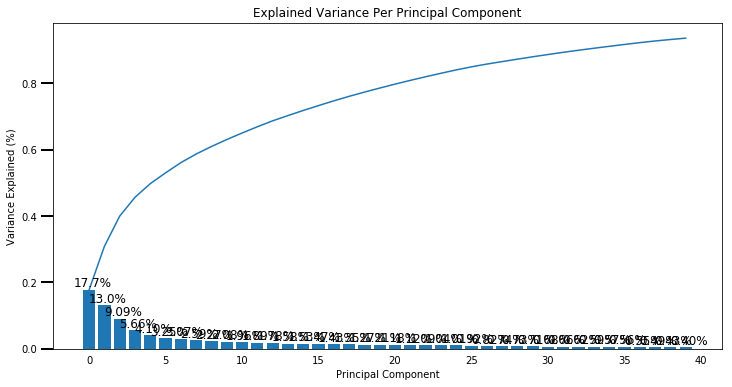

In [34]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component') 

scree_plot(pca)

In [35]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(10)
X_pca = pca.fit_transform(subset_fullval_cleaned_scaled)

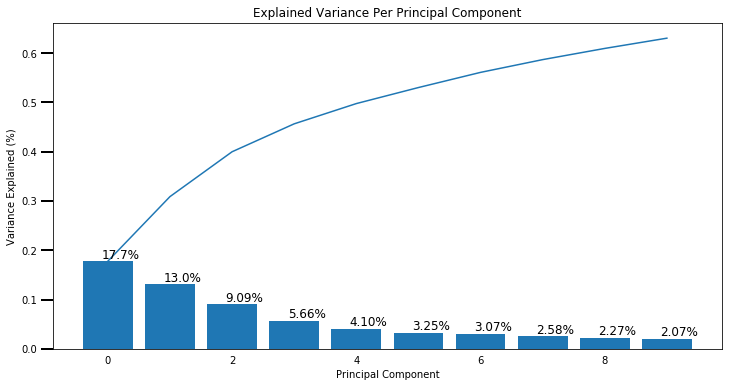

In [36]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)*

**I decided to retain 10  principal components / transformed features as this number of features adds up to a Explained Variance of more than 60%. This question was not so easy, I had to google a little bit and there is no right or wrong answer. However, I decided to look at the dimension when the added Explained Variance fell below 2%**

https://stackoverflow.com/questions/12067446/how-many-principal-components-to-take

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. **Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.**
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [37]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(full_dataset, pca, i):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    result = components.iloc[i,:].sort_values(ascending=False)
    
    # Return a concatenated DataFrame
    #return pd.concat([variance_ratios, components], axis = 1).iloc[3,:]#.sort_values(ascending=False)
    return print('Weights for Dimension '+str(i+1)+' with '+str(variance_ratios.iloc[i])), result.head(10), result.tail(10)

pca_results(subset_fullval_cleaned, pca, 0)

Weights for Dimension 1 with Explained Variance    0.1778
Name: Dimension 1, dtype: float64


(None, PLZ8_ANTG3            0.2162
 PLZ8_ANTG4            0.2109
 PLZ8_BAUMAX           0.2078
 WEALTH                0.1949
 HH_EINKOMMEN_SCORE    0.1913
 ORTSGR_KLS9           0.1878
 EWDICHTE              0.1844
 FINANZ_HAUSBAUER      0.1509
 KBA05_ANTG4           0.1469
 PLZ8_ANTG2            0.1429
 Name: Dimension 1, dtype: float64, LP_LEBENSPHASE_GROB   -0.1306
 LP_LEBENSPHASE_FEIN   -0.1460
 INNENSTADT            -0.1565
 KONSUMNAEHE           -0.1583
 PLZ8_GBZ              -0.1651
 FINANZ_MINIMALIST     -0.2055
 KBA05_GBZ             -0.2076
 KBA05_ANTG1           -0.2169
 PLZ8_ANTG1            -0.2178
 MOBI_REGIO            -0.2323
 Name: Dimension 1, dtype: float64)

In [38]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(subset_fullval_cleaned, pca, 1)

Weights for Dimension 2 with Explained Variance    0.1309
Name: Dimension 2, dtype: float64


(None, ALTERSKATEGORIE_GROB    0.2628
 SEMIO_ERL               0.2334
 FINANZ_VORSORGER        0.2302
 SEMIO_LUST              0.1821
 RETOURTYP_BK_S          0.1649
 SEMIO_KRIT              0.1193
 W_KEIT_KIND_HH          0.1193
 FINANZ_HAUSBAUER        0.1068
 SEMIO_KAEM              0.1062
 PLZ8_ANTG3              0.0863
 Name: Dimension 2, dtype: float64, SEMIO_RAT               -0.1758
 SEMIO_FAM               -0.1801
 FINANZ_ANLEGER          -0.2059
 SEMIO_KULT              -0.2196
 FINANZ_UNAUFFAELLIGER   -0.2267
 SEMIO_TRADV             -0.2323
 FINANZ_SPARER           -0.2385
 SEMIO_PFLICHT           -0.2413
 DECADE                  -0.2518
 SEMIO_REL               -0.2654
 Name: Dimension 2, dtype: float64)

In [39]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(subset_fullval_cleaned, pca, 2)

Weights for Dimension 3 with Explained Variance    0.091
Name: Dimension 3, dtype: float64


(None, SEMIO_VERT              0.3491
 SEMIO_SOZ               0.2639
 SEMIO_FAM               0.2518
 SEMIO_KULT              0.2326
 FINANZ_MINIMALIST       0.1614
 RETOURTYP_BK_S          0.1132
 FINANZ_VORSORGER        0.0964
 W_KEIT_KIND_HH          0.0894
 ALTERSKATEGORIE_GROB    0.0803
 SEMIO_REL               0.0781
 Name: Dimension 3, dtype: float64, FINANZ_UNAUFFAELLIGER   -0.0897
 FINANZ_SPARER           -0.1005
 DECADE                  -0.1050
 SEMIO_ERL               -0.1715
 FINANZ_ANLEGER          -0.1874
 SEMIO_RAT               -0.2173
 SEMIO_KRIT              -0.2708
 SEMIO_DOM               -0.3119
 SEMIO_KAEM              -0.3381
 ANREDE_KZ               -0.3680
 Name: Dimension 3, dtype: float64)

<a id='pca_interpretation'></a>

### Discussion 2.3: Interpret Principal Components

*(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)*

**The first 3 principal components add up to almost 40% explained variance. The positive values with the highest values signal a high positive correlation within the the component. This applies for the other positive criteria as well - they vary together. (source: https://newonlinecourses.science.psu.edu/stat505/node/54/) If one increases, then the remaining ones tend to increase as well. The negative values signal a negative correlation to the positive values and a positive correlation to the other negative values.**

The **first principal component (index=0)** seems for me to foucs on the positive side on the terms of 
  * whether there are a lot of familiy houses in the neighbourhood - high values suggest more houses, first 3 biggest positive weights:
    * **`PLZ8_ANTG3`** (Number of 6-10 family houses in the PLZ8 region)
    * **`PLZ8_ANTG4`** (Number of 10+ family houses in the PLZ8 region) and 
    * **`PLZ8_BAUMAX`** (Most common building type within the PLZ8 region) 
    * These are all ordinal features. For the first 2 the higher the count the more family homes are in the region. The higher the count also the higher the impact on the first principal component. For **`PLZ8_BAUMAX`** it's the opposite - a high value shows mainly 10+ family homes or mainly business buildings
  * **`WEALTH`** (4th biggest weight, high values indicate lower wealth) and
  * **`HH_EINKOMMEN_SCORE`** (Estimated household net income, high values suggest low income)
  * Also **`FINANZ_HAUSBAUER`** is weighed very high, however high values are "bad" here (bad means not owning a house), so this feature suggests that the person rather not owns a house.

For the negative features 
  * **`MOBI_REGIO`** (Movement patterns, low values suggest high movement behaviour),
  * **`PLZ8_ANTG1`** (Number of 1-2 family houses in the PLZ8 region, low values suggest "no 1-2 family homes"), 
  * **`KBA05_ANTG1`** (Number of 1-2 family houses in the microcell), 
  * **`KBA05_GBZ`** (Number of buildings in the microcell, low values suggest only few buildings) and 
  * **`FINANZ_MINIMALIST`** (Financial typology, low financial interest, low values suggest very high approval) are dominating. 
  
**Interpretation: This principal component increases if the person tends to be less wealthy (plus low income), tends to move very often, does not own a house, doesn't care a lot about accumulating money (FINANZ_MINIMALIST) and lives in areas with family homes but rather in bigger buildings as tenant (and thus fewer houses - KBA05_GBZ).**

The **second principal component (index=1)** tends to foucs on the positive side on the terms 
  * **`ALTERSKATEGORIE_GROB`** (Estimated age based on given name analysis, high values suggest elderly persons), 
  * **`SEMIO_ERL`** (Personality typology, event-oriented, high values suggest low affinity), 
  * **`FINANZ_VORSORGER`** (Financial typology, be prepared, high values suggest low preparation), 
  * **`SEMIO_LUST`** (Personality typology, sensual-minded, high values suggest low affinity) and 
  * **`RETOURTYP_BK_S`** (shopping and retouring behaviour, high values suggest "conservative Low-Returner" or "determined Minimal-Returner") 

Highest negative values: 
  * **`SEMIO_REL`** (Personality typology, religious, low values suggest high affinity), 
  * **`DECADE`** (low values suggest eldery persons), 
  * **`SEMIO_PFLICHT`** (Personality typology, dutiful, low values suggest high affinity),
  * **`FINANZ_SPARER`** (Financial typology, money-saver, low values suggest high approval) and
  * **`SEMIO_TRADV`** (Personality typology, tradional-minded, low values suggest high affinity)

**Interpretation: This principal component increases if the person is rather older, has a low-returning shopping behaviour (which might indicate no or less online shopping), is more dutiful, religious and traditional. Might be a saver (FINANZ_SPARER), but not in terms of preparing for long future (no FINANZ_VORSORGER).**

The **third principal component  (index=2)** tends to foucs on the positive side on the terms 
  * **`SEMIO_VERT`** (Personality typology, dreamful, high values suggest low affinity), 
  * **`SEMIO_SOZ`** (Personality typology, socially-minded, high values suggest low affinity), 
  * **`SEMIO_FAM`** (Personality typology, family-minded, high values suggest low affinity), 
  * **`SEMIO_KULT`** (Personality typology, cultural-minded, high values suggest low affinity) and 
  * **`FINANZ_MINIMALIST`** (Financial typology, low financial interest, high values suggest low approval)
  
Additionaly the negative values show a good picture what are the two extremes of the principal component: 
  * **`ANREDE_KZ`** (Gender, 1 is male and 2 female),  
  * **`SEMIO_KAEM`** (Personality typology, combative attitude, low values suggest high affinity), 
  * **`SEMIO_DOM`** (Personality typology, dominant-minded, low values suggest high affinity), 
  * **`SEMIO_KRIT`** (Personality typology, critical-minded, low values suggest high affinity) and 
  * **`SEMIO_RAT`** (Personality typology, rational, low values suggest high affinity)
  
**Interpretation: This principal component increases if the person perceives him-/herself not as dreamful, socially-mindedor as a family person. It also increases if it is a more combative, rational, dominant- and critial-minded person. It increases  if the person has low approval to low financial interest which means it increases if the person has financial interest with high affinity to financial investments (6th smallest feature).**

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [40]:
# Over a number of different cluster counts, run k-means clustering on the data and 
# compute the average within-cluster distances.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [41]:
%%time
scores = []
centers = np.arange(1,16).tolist()

Wall time: 999 µs


loop 1
Wall time: 12.2 s
loop 2
Wall time: 18.4 s
loop 3
Wall time: 56 s
loop 4
Wall time: 47.5 s
loop 5
Wall time: 1min 12s
loop 6
Wall time: 1min 13s
loop 7
Wall time: 1min 15s
loop 8
Wall time: 1min 50s
loop 9
Wall time: 2min 38s
loop 10
Wall time: 3min 17s
loop 11
Wall time: 8min 44s
loop 12
Wall time: 7min 6s
loop 13
Wall time: 6min 20s
loop 14
Wall time: 7min 3s
loop 15
Wall time: 9min 17s
Wall time: 52min 15s


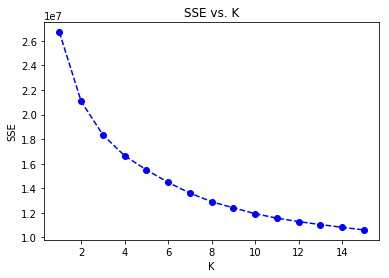

In [42]:
%%time
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
for center in centers:
    print('loop '+str(center))
    %%time scores.append(get_kmeans_score(X_pca, center)) 

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K'); 

In [43]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 12

In [44]:
%%time 
kmeans = KMeans(n_clusters=n_clusters)
labels_general = kmeans.fit_predict(X_pca)

Wall time: 5min 12s


### Discussion 3.1: Apply Clustering to General Population

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)*

**After applying clustering with different cluster counts, I defined n = 12 as the elbow of the curve (and so as the count of segments). I obtained the predicted Kmeans labels for the general population in a variable (`labels_general`).**

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. **Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data.** In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [45]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [46]:
%%time
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# preprocessing
customers_processed, customers_outliers = clean_data(customers)

Took unprocessed dataframe with shape(191652, 85)
6 outlier columns removed.
Multi-level categoricals dropped.
Re-enginerred and dropped "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015".
Outlier rows (>9 missing values) removed from dataframe.
Created 2nd dataframe with outlier rows (>9 missing values) for later analysis.
Returned cleaned dataframe with shape (139500, 68) and outlier dataframe with shape (52152, 68)
Wall time: 5.37 s


In [47]:
%%time
# feature transformation
# remove NaN values
customers_processed_cleaned = customers_processed[customers_processed.isnull().sum(axis=1) == 0]
#apply feature scaling
customers_processed_cleaned_scaled = feauture_scaling(customers_processed_cleaned)
# apply pca from general demograpichs pca object
customers_processed_cleaned_scaled_pca = pca.transform(customers_processed_cleaned_scaled)

Wall time: 2.73 s


In [48]:
# clustering
labels_customers = kmeans.predict(customers_processed_cleaned_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [49]:
# add label = 12 to both dataframes for datasets with NAN outliers
labels_general.shape

(623209,)

In [50]:
np.full((subset_missval.shape[0], ), 12).shape

(111220,)

In [51]:
labels_general = np.append(labels_general,
                           np.full((subset_missval.shape[0], ), 12))

In [52]:
labels_general.shape

(734429,)

In [53]:
labels_customers.shape

(122543,)

In [54]:
labels_customers = np.append(labels_customers,
                           np.full((customers_outliers.shape[0], ), 12))

In [55]:
labels_customers.shape

(174695,)

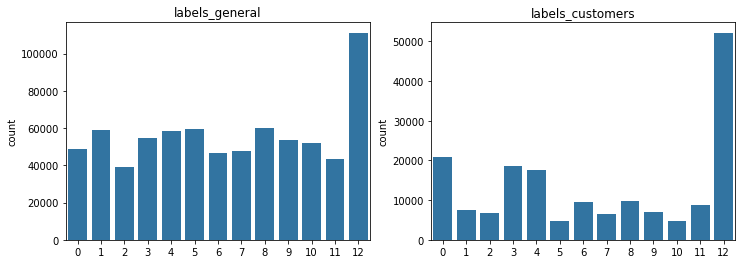

In [56]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
size = (12, 4)
base_color = sns.color_palette()[0]
    
fig, ax = plt.subplots(ncols=2, figsize=size);
plt.subplots_adjust(hspace = 0.2);

sns.countplot(labels_general, color=base_color, ax=ax[0]).set_title('labels_general');   
sns.countplot(labels_customers, color=base_color, ax=ax[1]).set_title('labels_customers');

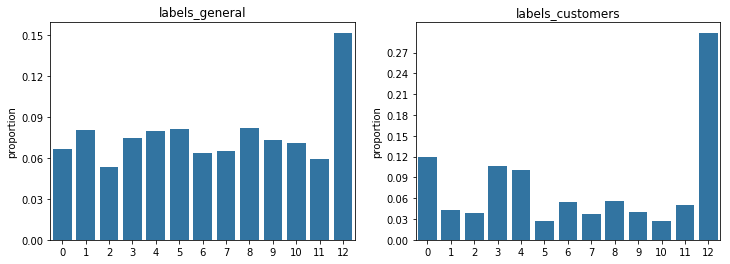

In [57]:
size = (12, 4)
base_color = sns.color_palette()[0]
count = 0

fig, ax = plt.subplots(ncols=2, figsize=size);
plt.subplots_adjust(hspace = 0.2);

for df in [labels_general, labels_customers]:
    # get proportion taken by most common group for derivation# of tick marks
    n_points = df.shape[0]
    max_count = pd.DataFrame(df, columns=['label']).groupby('label').size().max()
    max_prop = max_count / n_points
    
    # generate tick mark locations and names
    tick_props = np.arange(0, max_prop, 0.03)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]
    
    if count == 0:
        title = 'labels_general'
    else: 
        title = 'labels_customers'
    
    sns.countplot(df, color=base_color, ax=ax[count]).set_title(title)
    ax[count].set_ylabel('proportion')
    ax[count].set_yticks(tick_props * n_points)
    ax[count].set_yticklabels(tick_names)
    
    count=+1    

In [58]:
diffs_props = (pd.DataFrame(labels_customers, columns=['label']).groupby('label').size() / labels_customers.shape[0]) - (pd.DataFrame(labels_general, columns=['label']).groupby('label').size() / labels_general.shape[0])
diffs_props.sort_values(ascending=False)

label
12    0.147094
0     0.052342
3     0.031865
4     0.021521
6    -0.008730
11   -0.009520
2    -0.015160
8    -0.025920
7    -0.026942
9    -0.033058
1    -0.036955
10   -0.043298
5    -0.053239
dtype: float64

In [59]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print('Cluster with biggest positive difference of', diffs_props.max(), 'is the cluster with index', diffs_props.values.argmax())
print('Cluster with 2nd biggest positive difference of', diffs_props.drop(labels=[12]).max(), 'is the cluster with index', diffs_props.drop(labels=[12]).values.argmax())

Cluster with biggest positive difference of 0.14709435156560244 is the cluster with index 12
Cluster with 2nd biggest positive difference of 0.05234190640436108 is the cluster with index 0


In [70]:
kmeans.cluster_centers_[0]

array([-3.40029594,  0.0113324 ,  2.77821182,  2.25871805, -0.53581954,
       -0.31246006,  0.02213135, -0.02134848,  0.17145965,  0.29478693])

In [61]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print('Cluster with biggest negative difference of', diffs_props.min(), 'is the cluster with index', diffs_props.values.argmin())

Cluster with biggest negative difference of -0.05323928030211121 is the cluster with index 5


In [71]:
kmeans.cluster_centers_[5][:3]

array([ 4.60473664, -1.4935317 , -2.81664767])

In [68]:
pd.DataFrame(kmeans.cluster_centers_).T.iloc[:, [0]].sort_values(by=0, ascending=False)

,0
2,2.778212
3,2.258718
9,0.294787
8,0.171460
6,0.022131
1,0.011332
7,-0.021348
5,-0.312460
4,-0.535820
0,-3.400296


In [69]:
pd.DataFrame(kmeans.cluster_centers_).T.iloc[:, [5]].sort_values(by=5, ascending=False)

,5
0,4.604737
8,0.614864
3,0.509869
6,0.013957
4,-0.021206
9,-0.025775
5,-0.120331
7,-0.339810
1,-1.493532
2,-2.816648


In [65]:
pca_results(subset_fullval_cleaned, pca, 3)

Weights for Dimension 4 with Explained Variance    0.0567
Name: Dimension 4, dtype: float64


(None, GREEN_AVANTGARDE       0.3445
 EWDICHTE               0.2489
 ORTSGR_KLS9            0.2472
 LP_LEBENSPHASE_FEIN    0.2086
 LP_LEBENSPHASE_GROB    0.2048
 ANZ_PERSONEN           0.1894
 ONLINE_AFFINITAET      0.1694
 SEMIO_DOM              0.1184
 RELAT_AB               0.1048
 PLZ8_ANTG3             0.1020
 Name: Dimension 4, dtype: float64, WEALTH               -0.1048
 KONSUMNAEHE          -0.1243
 W_KEIT_KIND_HH       -0.1543
 REGIOTYP             -0.1561
 INNENSTADT           -0.2044
 KKK                  -0.2079
 BALLRAUM             -0.2144
 HH_EINKOMMEN_SCORE   -0.2398
 WOHNLAGE             -0.2605
 MOVEMENT             -0.3445
 Name: Dimension 4, dtype: float64)

### Discussion 3.3: Compare Customer Data to Demographics Data

*(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)*

*Interpretation of the Principal Components - https://newonlinecourses.science.psu.edu/stat505/node/54/*

<a href='#pca_interpretation'>Please also have a look at section "Discussion 2.3: Interpret Principal Components" where the first 3 principal components already have been discussed.</a>

**I would propose to look closer (prepare the mail campaign (template, content, targeting) for a similar audience) at the cluster with the label 0 as this cluster seems to be the overrepresented compared to the clusters from the general population dataset. Additionaly, the cluster with the label 5 appears to be underrepresented in the customer dataset, so this audience seems to be an audience that is not very interested in the Bertelsmann products. I have to admit, I don't really see why we had to add the cluster for the outliers with missing values, as this cluster is diluting the graphs and the difference proportions as well.**

**The most overrepresented cluster (and thus relatively popular) with the label 0 has three underlying principal components with great magnitude:** 
  * dimension 1 (index=0) with -3.400296
    * As the value is very low, I would guess the persons are the opposite of my previous interpretation (for increasing values) of dimension 1: Rather wealthy with high income, probably house owners with low movement behaviour.
  * dimension 3 (index=2) with 2.778212	
    * As outlined in my previous interpretation, this dimension increases if the person is rational, combative and critical-minded with high financial interest and affinity to financial investments.  
  * dimension 4 (index=3) with 2.258718
    * Dimension 4 increases if **`GREEN_AVANTGARDE`** (Membership in environmental sustainability as part of youth, biggest weight) is 1 (yes) and as the density of households per square kilometer increases (**`EWDICHTE`**), clearly from a urban region (**`ORTSGR_KLS9`**). Furthermore, it increases if the persons dominating movement in the youth (**`MOVEMENT`**, biggest negative weight) was rather 'avantgarde' (0 instead of 1) and he/she lives in a very good neighborhood (**`WOHNLAGE`**) near an urban center (**`BALLRAUM`**) with high purchasing power (**`KKK`**) and has a high estimated household net income (**`HH_EINKOMMEN_SCORE`**).  
  
**The most underrepresented cluster (and thus relatively unpopular) with the label 5 has three underlying principal components with great magnitude:** 
  * dimension 1 (index=0) with 4.604737
    * I would take my main thoughts from my interpretation for an increasing value of this dimension: tends to be less wealthy with low income, high movement behaviour, rather tenant and low financial interest.
  * dimension 2 (index=1) with -1.493532
    * Dimension 2 decreases if the person is rather younger, less dutiful, religious and traditional, with a higher returning shopping behaviour. Rather not a saver (**`FINANZ_SPARER`**).
  * dimension 3 (index=2) with -2.816648
    * Dimension 3 decreases if the person does rather not care so much about financial things and investments and has a high affinity to family, sociality and culture.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.